# Performing the inferences
## Merged Code

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../../..")

import gempy as gp
%matplotlib inline

import numpy as np
import pandas as pn
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Imports of libraries needed in the following code

from mpl_toolkits.mplot3d import Axes3D
import itertools
from scipy.spatial import ConvexHull

../../../gempy/posterior_analysis.py:31: UserWarning: tqdm package not installed. No support for dynamic progress bars.
  warnings.warn("tqdm package not installed. No support for dynamic progress bars.")


In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'serif',
              'transition': 'slide',
              'start_slideshow_at': 'selected',
              'scroll': True,
})

{'scroll': True,
 'start_slideshow_at': 'selected',
 'theme': 'serif',
 'transition': 'slide'}

### Creating the inital model

In [12]:
# Load data, define resolution 
# Note: resolution (res) and domain boundaries are defined beforehand now as variables as they are needed for 
# various causes later as well (like computing the centroids)
res = 32
xdown = 0; xup = 20; ydown = -5; yup = 15; zdown = -20; zup = 0

geo_data = gp.create_data([xdown,xup,ydown,yup,zdown,zup],[res, res, res],
                         path_o = "paper_Foliations.csv",
                         path_i = "paper_Points.csv")

geo_data.add_interface(X=10, Y=4, Z=-7, formation='fault1')

geo_data.interfaces.set_value(geo_data.interfaces['formation'] == 'Layer1', 'Z_std', 2)
geo_data.interfaces.set_value(geo_data.interfaces['formation'] == 'Layer2', 'Z_std', 2)


,X,Y,Z,formation,series,X_std,Y_std,Z_std,order_series,isFault,formation_number,annotations
0,4.345153,5.0,-1.921564,fault1,Default serie,NaN,NaN,NaN,1,False,1,"${\bf{x}}_{\alpha \,{\bf{1}},0}$"
1,10.000000,4.0,-7.000000,fault1,Default serie,NaN,NaN,NaN,1,False,1,"${\bf{x}}_{\alpha \,{\bf{1}},1}$"
2,2.303022,5.0,-1.647248,Unconformity,Default serie,NaN,NaN,NaN,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},0}$"
3,1.083840,5.0,-1.738687,Unconformity,Default serie,NaN,NaN,NaN,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},1}$"
4,8.825648,5.0,-3.140747,Unconformity,Default serie,NaN,NaN,NaN,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},2}$"
5,15.561631,5.0,-3.232185,Unconformity,Default serie,NaN,NaN,NaN,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},3}$"
6,2.211584,5.0,-5.518153,Layer1,Default serie,NaN,NaN,2,1,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},0}$"
7,11.172574,5.0,-6.981171,Layer1,Default serie,NaN,NaN,2,1,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},1}$"
8,15.104438,5.0,-8.108915,Layer1,Default serie,NaN,NaN,2,1,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},2}$"
9,2.059186,5.0,-4.908561,Layer2,Default serie,NaN,NaN,2,1,False,4,"${\bf{x}}_{\alpha \,{\bf{4}},0}$"


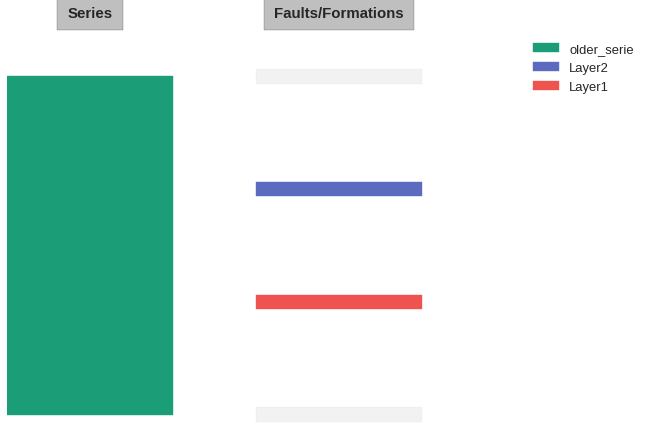

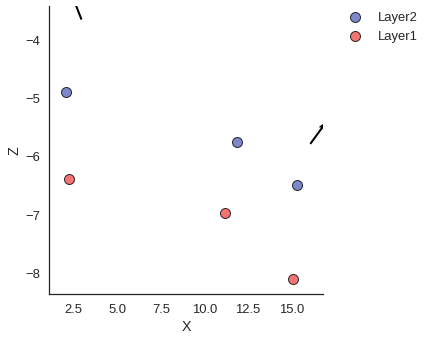

In [13]:
gp.set_series(geo_data, {'fault_serie1': 'fault1','younger_serie' : 'Unconformity', 'older_serie': ('Layer1', 'Layer2')},
              order_formations= ['fault1', 'Unconformity', 'Layer2', 'Layer1'], verbose=0)

geo_data.modify_interface(9, Z = -6.4)

geo_data = gp.select_series(geo_data, ['older_serie'])
gp.get_sequential_pile(geo_data)

gp.plot_data(geo_data)

In [14]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], dtype='float32', verbose=[])

lith, fault = gp.compute_model(interp_data)

ver_s, sim_s = gp.get_surfaces(interp_data,lith[1], None, original_scale=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


### Defining functions to compute gray voxels

In [15]:
def getBinLengthAndCenter(up, down, res):
    intervals  = np.arange(1, 2*res, 2)
    divide  = (up - down)/(2*res)
    centers = down + intervals*divide
    return divide, centers
    
# function to compute centroids of voxels in our domain
# returns coordinates of centroids and half the voxel length along each coordinate axis
def computeCentroids(xdown, xup, ydown, yup, zdown, zup, res):
    # Compute intervals
    dividex, possx = getBinLengthAndCenter(xup, xdown, res)
    dividey, possy = getBinLengthAndCenter(yup, ydown, res)
    dividez, possz = getBinLengthAndCenter(zup, zdown, res)
    
    # Get all centroids by combinations of x, y, z
    cposs = [possx, possy, possz]
    centroids = list(itertools.product(*cposs))
    
    return np.array(centroids), dividex, dividey, dividez

# Computing which voxels are cutted by which simpleces
# Functions
# radius corresponds to half the diagonal of the voxel
def computeVoxelRadius( xdown,  xup,  ydown, yup, zdown,  zup,  res):
    binSize = lambda up, down: (up - down)/res
    
    bin_size_x = binSize(xup, xdown)
    bin_size_y = binSize(yup, ydown)
    bin_size_z = binSize(zup, zdown)
    return np.sqrt(bin_size_x**2 + bin_size_y**2 + bin_size_z**2)/2

def dist(center, points):
    return np.sqrt( np.sum( (center - points)**2, axis=1) )

intersections = {'layer': [], 'voxel': [], 'simplex': []}

# @ students: check if this is still necessary
# calculate centroids of voxels in domain 
centroids, dividex, dividey, dividez = computeCentroids(xdown, xup, ydown, yup, zdown, zup, res)

# ++++++++++++++++
# Theano function t
import theano.tensor as T
import theano
theano.config.optimizer ='fast_run'
theano.config.openmp_elemwise_minsize = 50000
theano.config.openmp = True



x_1 = T.matrix()
x_2 = T.matrix()
radious = T.scalar()

    # T.maximum avoid negative numbers increasing stability
sqd = T.sqrt(T.maximum(
    (x_1**2).sum(1).reshape((x_1.shape[0], 1)) +
    (x_2**2).sum(1).reshape((1, x_2.shape[0])) -
    2 * x_1.dot(x_2.T), 0.000001
))

sqd_reshaped = sqd.reshape((-1, 3, sqd.shape[1]))

sqd_bool = T.lt(sqd_reshaped, radious)

check = T.prod(sqd_bool, axis=1)

indi = T.nonzero(check)

th_f = theano.function([x_1, x_2, radious], indi, allow_input_downcast=True)


# +++++++++++++++++++++
# Code to compute volume ratio in cutted voxels
# First compute plane of triangle cutting the voxel, then with plane function evaluate which points of voxel are 
# above and below, then compute with ConvexHull the volume ratio
class Plane:
    def __init__(self, three_poins):
        u = three_poins[1] - three_poins[0]
        v = three_poins[2] - three_poins[0]
        self.normal =  np.cross(u, v)
        self.const  = -np.dot(self.normal, three_poins[2])
        
    
    def evaluatePlaneEqn(self, points):
        return np.array([self.normal.dot(p) + self.const for p in points])
        
    def classify(self, points):
        """
        Decide which point is on top and which is below the plane.
        """
        residuals = self.evaluatePlaneEqn(points)
        upper     = np.where(residuals > 0.0)
        lower     = np.where(residuals < 0.0)
        return upper, lower
    

def uniqueTriNodes(tris):
    """
    Returns an array with the unique nodes in a list of triangles.
    """
    return np.array(list(set([tuple(row) for row in np.vstack(tris)])))

def getRatiosQuadTris(quad, tris):
    plane = Plane(tris[0])
    upper, lower = plane.classify(quad)
    
    tri_points = uniqueTriNodes(tris)
    upper_hull = ConvexHull(np.vstack([quad[upper], tri_points]))
    lower_hull = ConvexHull(np.vstack([quad[lower], tri_points]))
    
    upper_volume = upper_hull.volume
    lower_volume = lower_hull.volume
    total_volume = upper_volume + lower_volume
    return upper_volume/total_volume, lower_volume/total_volume


def getTriangle(layer_idx, sims_idx):
    return [ver_s[layer_idx][sim_s[layer_idx][i]] for i in sims_idx]

def getQuad(centroid, dx, dy, dz):
    
        
    # Calculate volume ratios of cutted voxels
    uni_vox_points = np.array([[-1, -1, -1], 
                               [ 1, -1, -1], 
                               [ 1,  1, -1], 
                               [-1,  1, -1], 
                               [-1, -1,  1], 
                               [ 1, -1,  1], 
                               [ 1,  1,  1], 
                               [-1,  1,  1]])
    
    return centroid + uni_vox_points*[dx, dy, dz]


### Plotting stuff

In [16]:
# # Here we can see the marching cube error and why with so little resolution does not work
# gp.plot_scalar_field(geo_data, lith[1], 2)
# ax = plt.gca()
# ax.set_xticks(np.linspace(0, 20, res, endpoint=False))
# ax.set_yticks(np.linspace(-10, 10, res, endpoint=False))
# plt.grid()

In [17]:
# # Plot centroids of the voxels as well as the corner points of the simplices of the different layers 
# fig = plt.figure()
# ax = Axes3D(fig)
# ax.scatter3D(*centroids.T, s=40, color='b', alpha=0.05)
# ax.scatter3D(*geo_data.grid.values.T, color='y', alpha=0.05)  # Now they are the same!
# ax.scatter3D(*ver_s[0].T,  s=40, color='g', alpha=1.0)
# ax.scatter3D(*ver_s[1].T,  s=40, color='r', alpha=1.0)
# ax.set_xlim(xdown, xup)
# ax.set_ylim(ydown, yup)
# ax.set_zlim(zdown, zup)

In [18]:
computeVoxelRadius(*geo_data.extent, geo_data.resolution[0])

0.54126587736527421

### Code to compute the gray voxels

In [19]:
def compute_gray_voxels(geo_data, sim_s, ver_s, size_chunk_max=200):
    # Running the loop with the theano function

    # The number of triangles to choose at every iteration. If you run out of memory
    # use a smaller number
    #size_chunk_max = 200



    # Computing the maximum radio. The error selecting multiple voxel comes
    # because the voxels are not cubes I think
    radious = computeVoxelRadius(*geo_data.extent, geo_data.resolution[0])
    
    centroids, dividex, dividey, dividez = computeCentroids(*geo_data.extent, geo_data.resolution[0])


    # Looping the layers
    for clayer, (sim_l, ver_l) in enumerate(zip(sim_s, ver_s)): # all the layers
        # Inint the slicing of triangles
        n_triangles_0 = 0

        # Selecting the size of the chunk of triangles
        if sim_l.shape[0]+1 < size_chunk_max:
            size_chunk = sim_l.shape[0]
        else:
            size_chunk = size_chunk_max 

        # Looping chunks of triangles
        for n_triangles_1 in np.linspace(size_chunk, sim_l.shape[0],( sim_l.shape[0]+1)/size_chunk, dtype=int):      

            # selecting chunk 
            ver_t = ver_l[sim_l][n_triangles_0:n_triangles_1]

            # Computing indices
            indices= th_f(ver_t.reshape(-1, 3), centroids, radious)

            # Storing results
            if n_triangles_0 is 0 and clayer is 0:
                layers = clayer*np.ones(indices[0].shape[0])
                voxels = indices[1]
                simpleces = indices[0]+n_triangles_0
            else:
                layers = np.hstack((layers, clayer*np.ones(indices[0].shape[0])))
                voxels = np.hstack((voxels, indices[1]))
                simpleces = np.hstack((simpleces,indices[0]+n_triangles_0))

            # Switching the slice interval
            n_triangles_0 = n_triangles_1
            
    # Passing the results to same format as it was before
    intersections = {'layer': [], 'voxel': [], 'simplex': []}


    intersections['voxel'] = voxels.astype(int)
    intersections['simplex'] = simpleces.astype(int)
    intersections['layer'] = layers.astype(int)



    n_interfaces  = len(np.unique(intersections['layer']))
    unique_voxels = np.unique(intersections['voxel'])

    voxel_ratio = np.zeros((len(unique_voxels), n_interfaces + 1))
    voxels = []
    
    for i, vox in enumerate(unique_voxels):
        voxels.append(vox)

        # Gather data
        indices = intersections['voxel'] == vox
        cutting_sims   = intersections['simplex'][indices]
        cutting_layers = intersections['layer'][indices]

        # Reconstruct the voxel (gives corner points of voxel)
        quad = getQuad(centroids[vox], dividex, dividey, dividez)

        unique_cutting_layers = np.unique(cutting_layers)

        # I am sorry for the confusing naming of variables. In the following we consider two cases. The voxel is only
        # cutted by one layer and the voxel is cutted by two layers. But actually those layers are interfaces between 
        # layers. So in the first case one interface is dividing the voxel in two layers. Upper_ratio gives the volume 
        # ratio of the layer above the interface and lower_ratio gives the volume ratio of the layer below the interface. 
        # In the second case is a bit more complicated. Here the voxel is cutted by two interfaces into three layers.
        # First we compute for the first interface (upper interface) only the volume ratio of the layer above. Then we 
        # compute for the second interface (lower interface, called third layer here)  the volume ratio of the layer below.
        # Now we are only missing the volume ratio of the layer between the two interfaces --> mid layer. We easily computing
        # by substracting the two other ratios of one. The code can only deal so far with voxels cutted by maximum two 
        # layers (which is sufficient for our model problem). For voxels cutted by more layers it gives a value error.

        if len(unique_cutting_layers) == 1: # voxel is cutted by one layer
            cutting_layer = cutting_layers[0]
            tri = getTriangle(cutting_layer, cutting_sims)
            upper_ratio, lower_ratio = getRatiosQuadTris(quad, tri)

            voxel_ratio[i, cutting_layer]     = upper_ratio
            voxel_ratio[i, cutting_layer + 1] = lower_ratio

        elif len(unique_cutting_layers) == 2: # voxel is cutted by two layers
            unique_cutting_layers = np.sort(unique_cutting_layers)

            # 1st layer
            ## Gather data
            first_layer = unique_cutting_layers[0]
            first_sims  = cutting_sims[cutting_layers == first_layer]
            tri = getTriangle(first_layer, first_sims)

            ## Computation
            first_ratio, _ = getRatiosQuadTris(quad, tri)

            ## Store result
            voxel_ratio[i, first_layer] = first_ratio


            # 3nd layer
            ## Gather data
            third_layer = unique_cutting_layers[1]
            third_sims  = cutting_sims[cutting_layers == third_layer]
            tri = getTriangle(third_layer, third_sims)

            ## Computation
            _, third_ratio = getRatiosQuadTris(quad, tri)


            ## Store result
            voxel_ratio[i, third_layer + 1] = third_ratio


            # Mid layer
            mid_layer = third_layer
            voxel_ratio[i, mid_layer] = 1 - first_ratio - third_ratio

        else:
            raise ValueError('Cannot compute more than 2 interfaces/layers cutting a voxel')
            
    weigths_df = pn.DataFrame(voxel_ratio, index=voxels)
    return weigths_df

In [44]:
weigths_df = compute_gray_voxels(geo_data, sim_s, ver_s, size_chunk_max=1000000)

/home/miguel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [32]:
weigths_df

,0,1,2
178,7.343155e-02,1.595960e-03,0.924972
191,9.559515e-03,5.621774e-04,0.989878
192,1.752375e-01,2.783430e-03,0.821979
193,3.525446e-01,2.749868e-03,0.644705
194,4.491703e-01,2.691052e-03,0.548139
195,5.008594e-01,2.650039e-03,0.496491
196,5.634232e-01,2.633859e-03,0.433943
197,7.159221e-01,2.646376e-03,0.281432
198,9.607972e-01,1.131037e-03,0.038072
209,4.515355e-03,2.604321e-04,0.995224


# Initial model gravity using gray voxels

This interp_daa is that used in the inference. We do not need to compile at every iteration!!!

In [22]:
# Here in verbose is set density block to see that some of the voxels have the density changed
# When making this stochastic it is better to delete it to avoid many prints
interp_data_grav = gp.InterpolatorData(geo_data, u_grade=[1], dtype='float32', verbose=[], output='gravity', theano_optimizer='fast_run')

In [23]:
# After compoling we need to set so
gp.set_geophysics_obj(interp_data_grav,  [0.1,19.9,-4.9,15.9, -20, 0], # Extent
                                             [1,1], ) # Resoluion of the measurement

In [24]:
# Now we compute the distances and the component z from the points where we want to compute gravity (in this case just 1 pixel)
# To all the voxels within a range
# This function also works to change the values of each rock type to densities
gp.precomputations_gravity(interp_data_grav, 1, [2.92, 3.1, 2.61]); 

In [25]:
# First we compile the theano function as ususal
interp_data_grav.th_fn = interp_data_grav.compile_th_fn(output='gravity')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_run
Device:  cpu
Precision:  float32


In [26]:
# @ students: this is only if you want to store the weigths in the hard disk
# weigths_df.to_pickle("weights.pickle")
# del weigths_df
# weigths_df = pn.read_pickle("weights.pickle")

In [27]:
# Now we need to set the indecies of voxels that are gray
interp_data_grav.interpolator.tg.weigths_index.set_value(weigths_df.index.values)

# And for those indeces the weighted density
interp_data_grav.interpolator.tg.weigths_weigths.set_value((weigths_df *  [2.92, 3.1, 2.61] ).values.sum(axis=1))

In [28]:
# This cell is in case you want to see the case of no-gray voxels for comparison
if False:
    interp_data_grav.interpolator.tg.weigths_index.set_value([])
    interp_data_grav.interpolator.tg.weigths_weigths.set_value([])

In [29]:
# Now we compute
lith, _, grav = gp.compute_model(interp_data_grav, output='gravity')

### Plotting

(-7, 17)

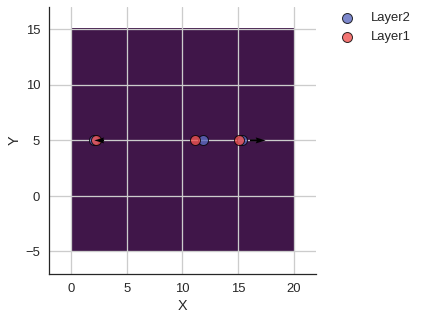

In [30]:
# Here we can plot the model and the gravity. Because we are doing just one voxel the image is not too sexy
gp.plot_section(geo_data, lith[-1], 5, direction='z',plot_data=True)

plt.grid()
fig = plt.gcf()
ax = plt.gca()
ax.imshow([grav], cmap='viridis', origin='lower', alpha=0.8, extent=[0,20,-5,15])
plt.xlim(-2,22)
plt.ylim(-7,17)

## Bayesian Inference

Here we can see the uncertainty we have. Basically 2 m of std in direction Z:

In [31]:
gp.get_data(geo_data, verbosity=2)

X  Y        Z       G_x          G_y      G_z     dip  \
interfaces   0  2.05919  5 -4.90856       NaN          NaN      NaN     NaN   
             1  11.8431  5 -5.76199       NaN          NaN      NaN     NaN   
             2  15.3178  5  -6.4935       NaN          NaN      NaN     NaN   
             3  2.21158  5     -6.4       NaN          NaN      NaN     NaN   
             4  11.1726  5 -6.98117       NaN          NaN      NaN     NaN   
             5  15.1044  5 -8.10891       NaN          NaN      NaN     NaN   
orientations 3  2.94296  5   -3.659 -0.365657   -6.717e-17  0.93075  21.448   
             2    16.08  5   -5.792  0.588166  3.60148e-17  0.80874  36.027   

               azimuth polarity  
interfaces   0     NaN      NaN  
             1     NaN      NaN  
             2     NaN      NaN  
             3     NaN      NaN  
             4     NaN      NaN  
             5     NaN      NaN  
orientations 3     270        1  
             2      90        1

But because we need to rescale everything before computing (this happens when we create the interp_data), the value we use in the distriburtions are... are wrong :D: FIXED!

In [32]:
gp.get_data(interp_data_grav.geo_data_res, verbosity=2)

X       Y         Z       G_x          G_y      G_z  \
interfaces   0    0.2501  0.5001  0.534884       NaN          NaN      NaN   
             1  0.599009  0.5001   0.50445       NaN          NaN      NaN   
             2   0.72292  0.5001  0.478363       NaN          NaN      NaN   
             3  0.255535  0.5001  0.481697       NaN          NaN      NaN   
             4  0.575096  0.5001  0.460972       NaN          NaN      NaN   
             5  0.715312  0.5001  0.420755       NaN          NaN      NaN   
orientations 3  0.281616  0.5001  0.579445 -0.365657   -6.717e-17  0.93075   
             2    0.7501  0.5001  0.503379  0.588166  3.60148e-17  0.80874   

                   dip azimuth polarity  
interfaces   0     NaN     NaN      NaN  
             1     NaN     NaN      NaN  
             2     NaN     NaN      NaN  
             3     NaN     NaN      NaN  
             4     NaN     NaN      NaN  
             5     NaN     NaN      NaN  
orientations 3  21.448     270        1  
             2  36.027      90        1

In [56]:
import pymc
interface_Z_stoch = []
foliations_dip_stoch = []
foliations_azimuth_stoch = []


# loop over the unique group id's and create a pymc.Normal distribution for each
for ind, i in interp_data_grav.geo_data_res.interfaces.iterrows():
    stoch = pymc.Normal(i['formation']+str(ind)+'_stoch', i['Z'], 1./i['Z_std']**2)
    interface_Z_stoch.append(stoch)

In [57]:
import copy
# First we extract from our original intep_data object the numerical data that is necessary for the interpolation.
# geo_data_stoch is a pandas Dataframe

# This is the inital model so it has to be outside the stochastic frame
geo_data_stoch_init = copy.deepcopy(interp_data_grav.geo_data_res)

In [58]:
gp.get_data(geo_data_stoch_init, numeric=True)

X       Y         Z       G_x           G_y      G_z  \
interfaces   0  0.250100  0.5001  0.768129       NaN           NaN      NaN   
             1  0.599009  0.5001  0.331190       NaN           NaN      NaN   
             2  0.722920  0.5001  0.603036       NaN           NaN      NaN   
             3  0.255535  0.5001  0.418916       NaN           NaN      NaN   
             4  0.575096  0.5001  0.580061       NaN           NaN      NaN   
             5  0.715312  0.5001  0.489504       NaN           NaN      NaN   
orientations 3  0.281616  0.5001  0.579445 -0.365657 -6.717004e-17  0.93075   
             2  0.750100  0.5001  0.503379  0.588166  3.601481e-17  0.80874   

                   dip  azimuth  polarity  
interfaces   0     NaN      NaN       NaN  
             1     NaN      NaN       NaN  
             2     NaN      NaN       NaN  
             3     NaN      NaN       NaN  
             4     NaN      NaN       NaN  
             5     NaN      NaN       NaN  
orientations 3  21.448    270.0       1.0  
             2  36.027     90.0       1.0

In [59]:
# Insert stochastic parameters to the input data. This are the prior we have to store

@pymc.deterministic(trace=True)
def input_data(value = 0, 
               interface_Z_modifier = interface_Z_stoch,
               geo_data_stoch_init = geo_data_stoch_init,
         
               verbose=0):
    # First we extract from our original intep_data object the numerical data that is necessary for the interpolation.
    # geo_data_stoch is a pandas Dataframe
    geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)

    geo_data_stoch.xs('interfaces')['Z'] = np.array(interface_Z_modifier)
  
    if verbose > 0:
        print(geo_data_stoch)
        
    # then return the input data to be input into the modeling function. Due to the way pymc2 stores the traces
    # We need to save the data as numpy arrays
    return [geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values, geo_data_stoch.xs('orientations').values]

In [60]:
# Computing the model and the gravity

@pymc.deterministic(trace=False)
def gempy_model(value=0,
                input_data=input_data, verbose=False):

    # modify input data values accordingly
    interp_data_grav.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]

    # Gx, Gy, Gz are just used for visualization. The theano function gets azimuth dip and polarity!!!
    interp_data_grav.geo_data_res.orientations[["G_x", "G_y", "G_z", "X", "Y", "Z", 'dip', 'azimuth', 'polarity']] = input_data[1]
    
    # you code here:
    

    ########################################################
    # @ students: We need to pass the sim and ver of the current iteration what sucks because it means
    # we need to compute the model twice for every model (doing it properly it is too difficult to implement)
    
    lith_, __, grav_ = gp.compute_model(interp_data_grav, output='gravity')
    ver_s, sim_s = gp.get_surfaces(interp_data_grav, lith_[1], None, original_scale=True)
    print(ver_s)
    weigths_df = compute_gray_voxels(geo_data, sim_s, ver_s)

    # Now we need to set the indecies of voxels that are gray
    interp_data_grav.interpolator.tg.weigths_index.set_value(weigths_df.index.values)

    # And for those indeces the weighted density
    interp_data_grav.interpolator.tg.weigths_weigths.set_value((weigths_df *  [2.92, 3.1, 2.61] ).values.sum(axis=1)) 
    
    
    try:
        lith_, __, grav_ = gp.compute_model(interp_data_grav, output='gravity')
        if False:
            gp.plot_section(interp_data_grav.geo_data_res, lb[0], 19, plot_data=True)

        return grav_
    
    except np.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
        return np.zeros_like(lith), np.zeros_like(_), np.zeros_like(grav)

# We want to store the value of gravity but the models better not. The following chunck is only for that
@pymc.deterministic(trace=True)
def gravity(value=0, model=gempy_model):
    return model  #[2] removed

# This is a hack to force to compute the models
@pymc.stochastic(trace=True)
def nothing(value=0, gravity=gravity):
    return 1



[array([[  0.54611649,   6.25      , -13.125     ],
       [  0.625     ,   6.25      , -13.23943675],
       [  0.625     ,   6.19318128, -13.125     ],
       ..., 
       [ 19.375     ,  13.05555582, -13.125     ],
       [ 19.375     ,  13.75      , -13.22979033],
       [ 19.375     ,  14.375     , -13.31031978]]), array([[  0.29166667,   5.625     , -13.125     ],
       [  0.625     ,   5.625     , -13.68055582],
       [  0.625     ,   5.40895104, -13.125     ],
       ..., 
       [ 19.375     ,  13.125     , -13.84698272],
       [ 19.375     ,  13.75      , -13.91410589],
       [ 19.375     ,  14.375     , -13.96959484]])]


/home/miguel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


QhullError: QH6214 qhull input error: not enough points(3) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options selected for Qhull 2015.2.r 2016/01/18:
  run-id 725155714  incidence  Qtriangulate  _pre-merge  _zero-centrum


In [ ]:
# Choosing the parameters which play a role
np.random.seed(123456) # I think with this is enough to draw always the same priors to be able to compare several resolutions but check the results to be sure!

p_model = pymc.Model([*interface_Z_stoch, input_data, gempy_model, gravity, nothing])

In [ ]:
S = pymc.MCMC(input=p_model, db="hdf5", dbname="r30")

In [ ]:
# Sampling
S.sample(5000)

Plotting Layer13_stoch
Plotting Layer22_stoch
Plotting Layer14_stoch
Plotting nothing
Plotting Layer21_stoch
Plotting Layer15_stoch
Plotting gravity_0
Plotting Layer20_stoch


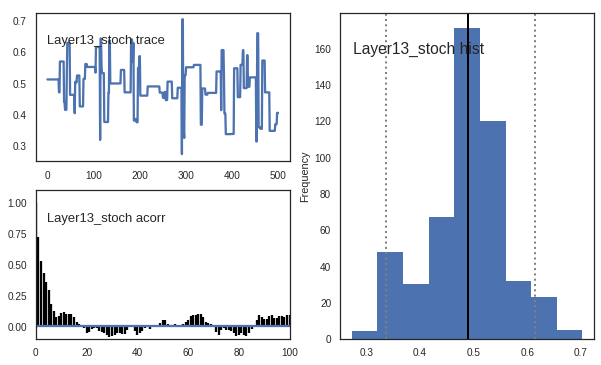

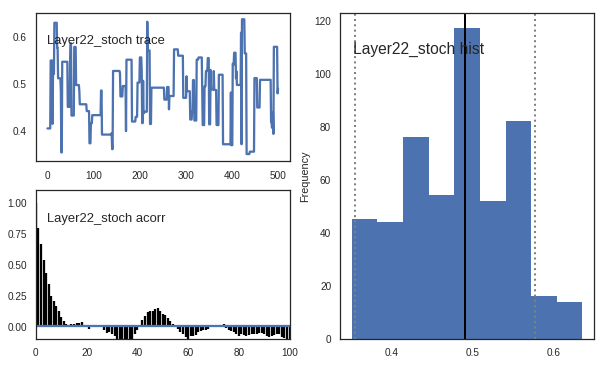

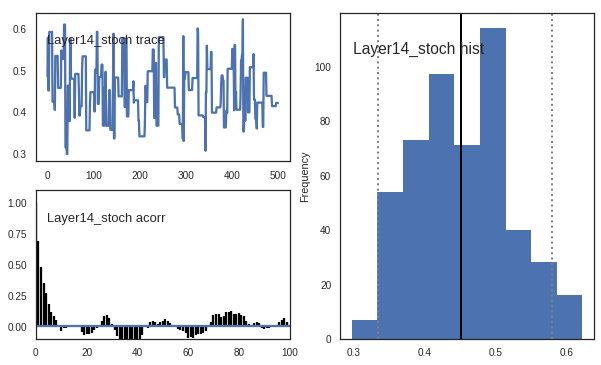

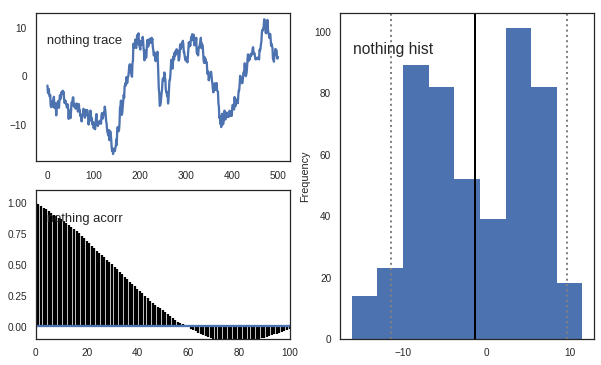

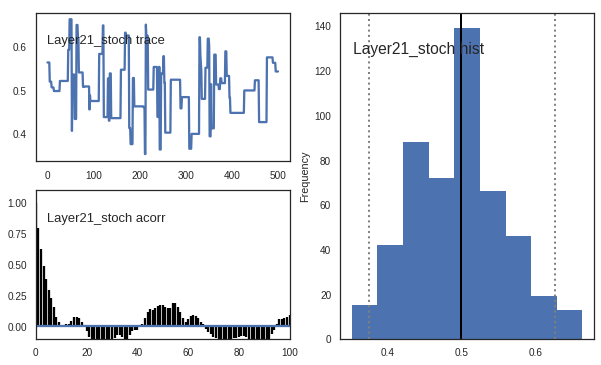

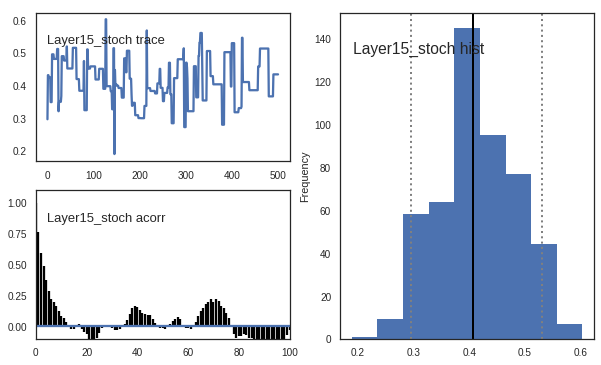

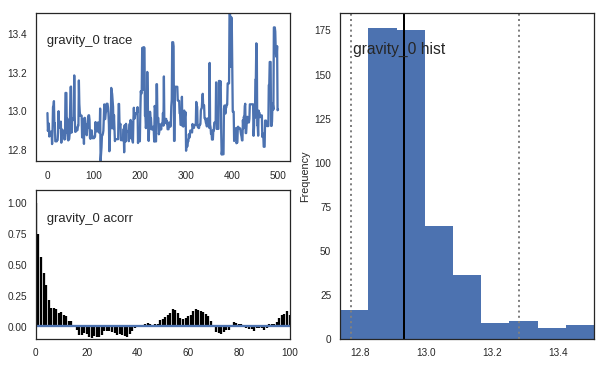

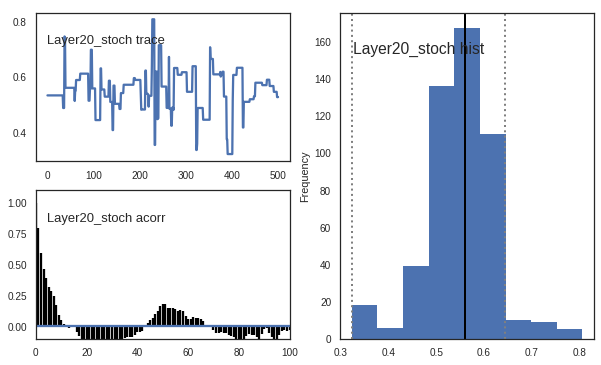

In [31]:
pymc.Matplot.plot(S, path='plot_traces')

## Evalutating posteriors: Not working properly yet!

### Code to change the resolution of the interp_data fast:

This part does not work for some reason:

In [ ]:
# However as we increase the resolution the model looks better and better! This I guess it is the marching cube error
new_grid = gp.GridClass()
res = 10


# Create a new grid object with the new resolution
new_grid.create_regular_grid_3d([xdown,xup,ydown,yup,zdown,zup],[res, res, res])

# Setting the new grid to the geodata
gp.set_grid(geo_data, new_grid)

# Update the interp_data
interp_data_grav.update_interpolator(geo_data)

# Recomputiong
lith, fault, new_grav = gp.compute_model(interp_data_grav, output='gravity')


### Code to change the iteration fast!

Here again we need to change the interp_data to the target iteration but then to recompute the gravity we need to compute the gray voxels first:

In [29]:
# This object reads the database directly making quite easy to modify an interp_data with any trace
post = gp.pa.Posterior("test")

In [ ]:
post.change_input_data(interp_data_grav, 45)

lith_, __, grav_ = gp.compute_model(interp_data_grav, output='gravity')
ver_s, sim_s = gp.get_surfaces(interp_data_grav, lith_[1], None, original_scale=True)

weigths_df = compute_gray_voxels(geo_data, sim_s, ver_s)

# Now we need to set the indecies of voxels that are gray
interp_data_grav.interpolator.tg.weigths_index.set_value(weigths_df.index.values)

# And for those indeces the weighted density
interp_data_grav.interpolator.tg.weigths_weigths.set_value((weigths_df *  [2.92, 3.1, 2.61] ).values.sum(axis=1)) 

lith, fault, new_grav = gp.compute_model(interp_data_grav, output='gravity')

new_grav

### Putting all together: Fancy function to choose the resoltuion and the grid

In [102]:
def recompute_grav(initial_geo_data, initial_interp_data, poterior_db, resolution, iteration):
    # =================
    # Change resolution
    new_grid = gp.GridClass()
    res = resolution
    # Create a new grid object with the new resolution
    new_grid.create_regular_grid_3d([*initial_geo_data.extent],[res, res, res])

    # Setting the new grid to the geodata
    gp.set_grid(initial_geo_data, new_grid)

    # Update the interp_data
    interp_data_grav.update_interpolator(initial_geo_data)
    
    # ================
    # Change iteration
    
    post.change_input_data(interp_data_grav, iteration)
    
    # ===================
    # Recomputing gravity
    
    
    lith_, __, grav_ = gp.compute_model(interp_data_grav, output='gravity')
    
    ver_s, sim_s = gp.get_surfaces(interp_data_grav, lith_[1], None, original_scale=True)
    
    weigths_df = compute_gray_voxels(initial_geo_data, sim_s, ver_s)

    # Now we need to set the indecies of voxels that are gray
    interp_data_grav.interpolator.tg.weigths_index.set_value(weigths_df.index.values)

    # And for those indeces the weighted density
    interp_data_grav.interpolator.tg.weigths_weigths.set_value((weigths_df *  [2.92, 3.1, 2.61] ).values.sum(axis=1)) 

    lith, fault, new_grav = gp.compute_model(interp_data_grav, output='gravity')

    return new_grav

In [103]:
# This object reads the database directly making quite easy to modify an interp_data with any trace
post = gp.pa.Posterior("test")

In [110]:
recompute_grav(geo_data, interp_data_grav, post, 20, 45)

array([ 12.35470295], dtype=float32)

In [113]:
for i in range(10, 40):
    try:
        recompute_grav(geo_data, interp_data_grav, post, i, 45)
    except:
        print(i)
    

10
11
12
13
14
15
16
17
18
19
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
